# Building a song recommender 

- content based filtering
- based on artist/genre/other features #
- sentiment analysis on the lyrics #
- clustering 

In [77]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans 
from sklearn.preprocessing import LabelEncoder 
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics.pairwise import sigmoid_kernel
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans 
from sklearn.preprocessing import MinMaxScaler 

In [2]:
df = pd.read_csv('spotify_songs.csv')
df.head()

,track_id,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
0,0017A6SJgTbfQVU2EtsPNo,Pangarap,Barbie's Cradle,Minsan pa Nang ako'y napalingon Hindi ko alam ...,41,1srJQ0njEQgd8w4XSqI4JQ,Trip,2001-01-01,Pinoy Classic Rock,37i9dQZF1DWYDQ8wBxd7xt,...,-10.068,1,0.0236,0.27900,0.01170,0.0887,0.566,97.091,235440,tl
1,004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,2017-11-21,Hard Rock Workout,3YouF0u7waJnolytf9JCXf,...,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512,en
2,00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,6oZ6brjB8x3GoeSYdwJdPc,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",3a9y4eeCJRmG9p4YKfqYIx,...,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467,en
3,00cqd6ZsSkLZqGMlQCR0Zo,Baby It's Cold Outside (feat. Christina Aguilera),CeeLo Green,I really can't stay Baby it's cold outside I'v...,41,3ssspRe42CXkhPxdc12xcp,CeeLo's Magic Moment,2012-10-29,Christmas Soul,6FZYc2BvF7tColxO8PBShV,...,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067,en
4,00emjlCv9azBN0fzuuyLqy,Dumb Litty,KARD,Get up out of my business You don't keep me fr...,65,7h5X3xhh3peIK9Y0qI5hbK,KARD 2nd Digital Single ‘Dumb Litty’,2019-09-22,K-Party Dance Mix,37i9dQZF1DX4RDXswvP6Mj,...,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160,en


In [18]:
df.duplicated().sum() # no duplicate rows 

0

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18454 entries, 0 to 18453
Data columns (total 25 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   track_id                  18454 non-null  object 
 1   track_name                18454 non-null  object 
 2   track_artist              18454 non-null  object 
 3   lyrics                    18194 non-null  object 
 4   track_popularity          18454 non-null  int64  
 5   track_album_id            18454 non-null  object 
 6   track_album_name          18454 non-null  object 
 7   track_album_release_date  18454 non-null  object 
 8   playlist_name             18454 non-null  object 
 9   playlist_id               18454 non-null  object 
 10  playlist_genre            18454 non-null  object 
 11  playlist_subgenre         18454 non-null  object 
 12  danceability              18454 non-null  float64
 13  energy                    18454 non-null  float64
 14  key   

In [7]:
catcols = []
numcols = []
for column in df.columns:
    if df[column].dtype == 'O':
        catcols.append(column)
    else:
        numcols.append(column)
print(len(catcols), len(numcols))
print(catcols)
print(numcols)

12 13
['track_id', 'track_name', 'track_artist', 'lyrics', 'track_album_id', 'track_album_name', 'track_album_release_date', 'playlist_name', 'playlist_id', 'playlist_genre', 'playlist_subgenre', 'language']
['track_popularity', 'danceability', 'energy', 'key', 'loudness', 'mode', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo', 'duration_ms']


In [19]:
print(len(df.track_artist.unique())) # 6031 artists 

6031


In [22]:
df.playlist_genre.value_counts()

pop      3993
rock     3521
rap      3391
r&b      3326
latin    2178
edm      2045
Name: playlist_genre, dtype: int64

In [23]:
df.playlist_subgenre.value_counts()

indie poptimism              1288
southern hip hop             1158
neo soul                     1001
electropop                    964
urban contemporary            936
hard rock                     926
classic rock                  924
post-teen pop                 891
new jack swing                881
gangster rap                  865
dance pop                     850
permanent wave                843
album rock                    828
hip hop                       689
trap                          679
latin hip hop                 673
progressive electro house     652
latin pop                     594
pop edm                       575
hip pop                       508
electro house                 484
tropical                      473
reggaeton                     438
big room                      334
Name: playlist_subgenre, dtype: int64

In [24]:
df.language.value_counts()

en    15405
es     1705
de      241
pt      176
it      133
pl       76
nl       72
fr       65
tl       63
da       40
id       34
ko       29
vi       24
ro       16
sw       16
so       16
cy       12
no       10
hi       10
ja        8
et        7
af        5
sv        5
tr        5
ru        4
hr        3
sq        3
el        2
ca        2
ar        2
cs        2
fi        1
hu        1
sk        1
Name: language, dtype: int64

In [ ]:
# label encoding useful categorical variables 

## Numerical Columns 

In [20]:
numcols

['track_popularity',
 'danceability',
 'energy',
 'key',
 'loudness',
 'mode',
 'speechiness',
 'acousticness',
 'instrumentalness',
 'liveness',
 'valence',
 'tempo',
 'duration_ms']

# Content (lyrics) based filtering 

In [49]:
# lowercasing where needed 
for col in ['track_name', 'track_artist', 'lyrics', 'track_album_name', 
            'playlist_name', 'playlist_genre', 'playlist_subgenre']:
    df[col] = df[col].str.lower()

In [46]:
print(df.head(1)['lyrics'])

0    minsan pa nang ako'y napalingon hindi ko alam ...
Name: lyrics, dtype: object


- A recommendation system is based on pairwise similarities such as the cosine similarities, hence we need vectorization in life 

- TfidfVectorizer() converts sentences into document matrices (NLP concept) -- will take deeper look

In [47]:
tf = TfidfVectorizer(min_df = 3, max_features = None, strip_accents = 'unicode',
                    analyzer = 'word', token_pattern = r'\w{1,}',
                    ngram_range = (1, 3),
                    stop_words = 'english') # removes all unnecessary strings such as 'the'

# filling NaNs with empty string
df['lyrics'] = df.lyrics.fillna('')

In [51]:
tf_matrix = tf.fit_transform(df.lyrics) # gives sparse matrix 
tf_matrix

<18454x275471 sparse matrix of type '<class 'numpy.float64'>'
	with 3133297 stored elements in Compressed Sparse Row format>

In [52]:
tf_matrix.shape # here features are combinations of words 

(18454, 275471)

**now we detect similar records**

In [53]:
sig = sigmoid_kernel(tf_matrix, tf_matrix)
sig[0]

array([0.76159568, 0.76159416, 0.76159416, ..., 0.76159416, 0.76159416,
       0.76159449])

In [54]:
indices = pd.Series(df.index, index = df.track_name)  # this will be later used to get the index of the songs 
indices

track_name
pangarap                                                 0
i feel alive                                             1
poison                                                   2
baby it's cold outside (feat. christina aguilera)        3
dumb litty                                               4
                                                     ...  
rising like the sun - radio mix                      18449
anaconda                                             18450
bound                                                18451
i'll do 4 u (re-recorded / remastered)               18452
migraine                                             18453
Length: 18454, dtype: int64

In [55]:
indices['Pangarap'.lower()]

0

In [76]:
df.track_name.duplicated().sum()

3460

In [71]:
# content based recommendations 
# can also sort according to popularity 

## FLAW: Songs may have same name

def recommend(name, sig = sig):
    name = name.lower()
    ind = indices[name]
    
    # pairwise similarity scores 
    sig_sc = list(enumerate(sig[ind]))
    
    # sort the songs 
    sig_sc = sorted(sig_sc, key = lambda x: x[1], reverse = True)
    
    # Scores of the 5 most similar songs 
    sig_sc = sig_sc[1 : 6]
    
    # song indices 
    song_ind = [i[0] for i in sig_sc]
    
    # top 5 most similar songs based on lyrics 
    return df[['track_name', 'track_artist', 'track_popularity', 'track_album_name', 'playlist_genre', 'playlist_subgenre']].iloc[song_ind].sort_values(by = 'track_popularity', ascending = False)

In [72]:
# testing
recommend('Love me Like You Do')

,track_name,track_artist,track_popularity,track_album_name,playlist_genre,playlist_subgenre
9381,"love me like you do - from ""fifty shades of grey""",ellie goulding,77,delirium (deluxe),pop,electropop
593,love me like you do,ellie goulding,64,fifty shades freed (original motion picture so...,pop,post-teen pop
12897,love him like i do,deitrick haddon,46,revealed,r&b,urban contemporary
16153,nobody,local sound,46,nobody,pop,dance pop
9857,obsessed,hogland,0,obsessed,edm,pop edm


In [74]:
recommend('kiss you')

,track_name,track_artist,track_popularity,track_album_name,playlist_genre,playlist_subgenre
2093,gettin' jiggy wit it,will smith,70,big willie style,pop,dance pop
16775,land of 1000 dances,wilson pickett,61,the exciting wilson pickett,r&b,urban contemporary
5765,hey jude - remastered 2009,the beatles,39,past masters (vols. 1 & 2 / remastered),rock,classic rock
15558,hell on wheels,nick nolan,36,outlaw blues 2,rap,southern hip hop
3449,a minute to breathe,trent reznor and atticus ross,33,before the flood (music from the motion picture),pop,indie poptimism


In [106]:
df.iloc[593]

track_id                                               0Cy7wt6IlRfBPHXXjmZbcP
track_name                                                love me like you do
track_artist                                                   ellie goulding
lyrics                      na you're the light, you're the night you're t...
track_popularity                                                           64
track_album_id                                         4w0N1CaZwQ5RPIuawqlYyy
track_album_name            fifty shades freed (original motion picture so...
track_album_release_date                                           2018-02-09
playlist_name                                                   post teen pop
playlist_id                                            6rjxP7GQKoqqgoakzxl3PY
playlist_genre                                                            pop
playlist_subgenre                                               post-teen pop
danceability                                                    

# Clustering 
ref 1: https://realpython.com/k-means-clustering-python/#:~:text=The%20k%2Dmeans%20clustering%20method,data%20objects%20in%20a%20dataset.&text=You'll%20walk%20through%20an,the%20data%20to%20evaluating%20results.

ref 2: http://www.socr.umich.edu/people/dinov/courses/DSPA_notes/12_kMeans_Clustering.html#:~:text=Unsupervised%20Feature%20Selection%20for%20k,of%20important%20features%20are%20chosen.
- based on what song the user selects, recommend more songs from the same cluster 

In [78]:
features = df[numcols]
features.head()

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,41,0.682,0.401,2,-10.068,1,0.0236,0.27900,0.01170,0.0887,0.566,97.091,235440
1,28,0.303,0.880,9,-4.739,1,0.0442,0.01170,0.00994,0.3470,0.404,135.225,373512
2,0,0.845,0.652,6,-7.504,0,0.2160,0.00432,0.00723,0.4890,0.650,111.904,262467
3,41,0.425,0.378,5,-5.819,0,0.0341,0.68900,0.00000,0.0664,0.405,118.593,243067
4,65,0.760,0.887,9,-1.993,1,0.0409,0.03700,0.00000,0.1380,0.240,130.018,193160


In [79]:
# # feature scaling 
# sc = MinMaxScaler()
# features[numcols] = sc.fit_transform(features)
# scaled[0]

In [84]:
# feature scaling 
sc = MinMaxScaler()
features[numcols] = sc.fit_transform(features[numcols])
features.head()

<ipython-input-84-34c3dd792279>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features[numcols] = sc.fit_transform(features[numcols])
C:\Users\Sarah Mathew\anaconda3\lib\site-packages\pandas\core\indexing.py:1736: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, value[:, i].tolist())


,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
0,0.41,0.662692,0.390827,0.181818,0.681000,1.0,0.001340,0.281249,0.011854,0.080414,0.571136,0.338981,0.418893
1,0.28,0.232254,0.877962,0.818182,0.830868,1.0,0.024341,0.011793,0.010071,0.342212,0.407663,0.554509,0.703040
2,0.00,0.847814,0.646090,0.545455,0.753108,0.0,0.216168,0.004353,0.007325,0.486135,0.655900,0.422702,0.474513
3,0.41,0.370812,0.367436,0.454545,0.800495,0.0,0.013064,0.694556,0.000000,0.057812,0.408672,0.460508,0.434589
4,0.65,0.751278,0.885081,0.818182,0.908094,1.0,0.020657,0.037297,0.000000,0.130382,0.242172,0.525080,0.331882


In [85]:
km = KMeans(n_clusters = 50)
km1 = km.fit(features)

In [87]:
km1.inertia_ # lowest error SSE

3249.2559490471144

In [88]:
km1.n_iter_

56

In [89]:
km1.labels_

array([14,  8,  9, ..., 16, 34,  4])

## Choosing appropriate number of clusters 
- Based on numerical columns
- figure out how to include other important features such as genre anf language 
- one hot encoding too many features 

In [91]:
sse = []
for k in range(1, 96):                          # 96 ~ root(n/2) conventional value for k
    kmeans = KMeans(n_clusters = k)
    kmeans.fit(features)
    sse.append(kmeans.inertia_)

In [95]:
len(sse)

95

In [97]:
pd.Series(sse).min()

2756.897763854404

In [99]:
for i in range(len(sse)):
    if sse[i] == pd.Series(sse).min():
        print(i)
        
# ideal k: 94

94


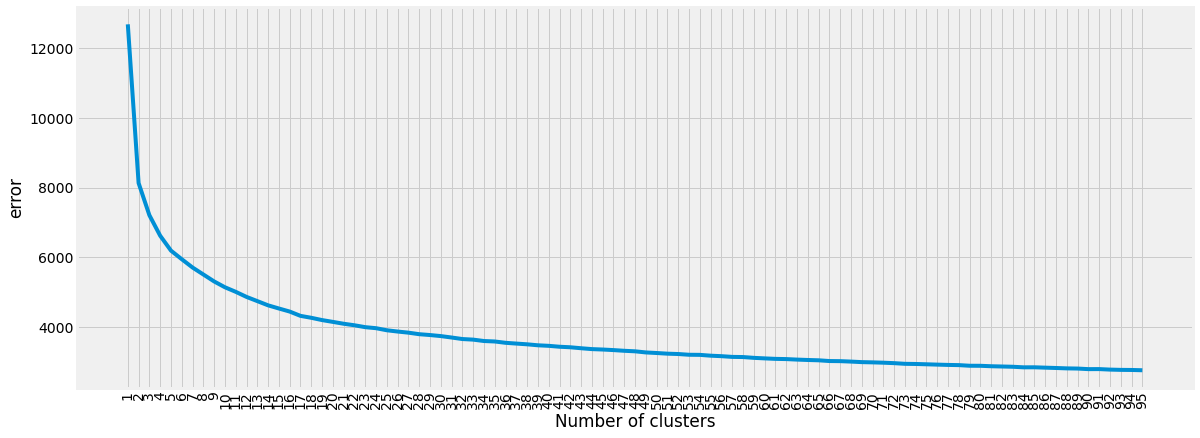

In [105]:
plt.figure(figsize = (20, 7))
plt.style.use("fivethirtyeight")
plt.plot(range(1, 96), sse)
plt.xticks(range(1, 96), rotation = 90)
plt.xlabel('Number of clusters')
plt.ylabel('error')
plt.show()

In [120]:
km = KMeans(n_clusters = 94)
km2 = km.fit(features)

In [121]:
km2.inertia_ # lowest error SSE

2763.6549196322244

In [122]:
km2.n_iter_

85

In [123]:
km2.labels_

array([14, 82, 90, ...,  8, 67, 91])

In [124]:
# clusters 
clusters = pd.DataFrame()
clusters['data_index'] = df.index.values
clusters['cluster'] = km2.labels_

In [125]:
x = pd.DataFrame(features.iloc[5765]).transpose() # love me like you do
x

,track_popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms
593,0.64,0.443498,0.590156,0.454545,0.777603,0.0,0.007593,0.272176,0.0,0.096935,0.326936,0.327231,0.456101


In [127]:
km2.predict(x)

array([49])

In [140]:
df.iloc[clusters[clusters.cluster == 49].index].to_csv('ll.csv')